In [1]:
import sys
sys.path.append('../tools')
import sglicod

In [2]:
import os
os.chdir('/home/gray/school/kaji')
print(os.getcwd())

/home/gray/school/kaji


### 📍選択場所

長崎県長崎市周辺

緯度経度：　32.77385187483379, 129.96776479536018

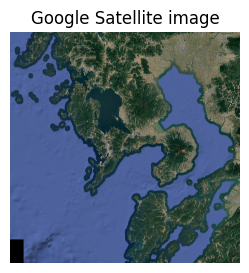

In [3]:
import rasterio
import matplotlib.pyplot as plt

tif = "data/ndvi_center_satellite.tif"

with rasterio.open(tif) as src:
    img = src.read([1, 2, 3])  # RGB
    img = img.transpose(1, 2, 0)

plt.figure(figsize=(3, 3))
plt.imshow(img)
plt.axis("off")
plt.title("Google Satellite image")
plt.show()

In [4]:
img_size = 4800
lon = 129.96776479536018
lat = 32.77385187483379

V, H, imgX, imgY = sglicod.sgli_ll2tile_B0(img_size, lon, lat)
print("T0", V, H)
print(V, H, imgX, imgY)

T0 5 28
5 28 4453.767288811825 3468.5511000797815


### 📅 Sentinel-2 を用いた GCOM-C 撮影日候補の抽出

空間分解能が高く、雲量情報が利用しやすい Sentinel-2 L2A を参考データとして用い、
以下の条件で撮影日候補を抽出する。

対象地点：解析対象領域（bbox）

期間：指定した解析期間　（2024-07-01/2024-10-31）

条件：シーン全体の雲量が 5% 未満

In [5]:
from pyproj import Geod

def bbox_square_geodesic(lon, lat, side_km):
    """
    Create an axis-aligned (N/E/S/W) square bbox centered at (lon, lat),
    with side length = side_km, using geodesic calculations.
    Returns: [min_lon, min_lat, max_lon, max_lat]
    """
    g = Geod(ellps="WGS84")
    half_m = (side_km * 1000.0) / 2.0

    # Move from center by half_m to N, S, E, W
    lon_n, lat_n, _ = g.fwd(lon, lat, 0,   half_m)
    lon_s, lat_s, _ = g.fwd(lon, lat, 180, half_m)
    lon_e, lat_e, _ = g.fwd(lon, lat, 90,  half_m)
    lon_w, lat_w, _ = g.fwd(lon, lat, 270, half_m)

    min_lon = min(lon_w, lon_e)
    max_lon = max(lon_w, lon_e)
    min_lat = min(lat_s, lat_n)
    max_lat = max(lat_s, lat_n)

    return [min_lon, min_lat, max_lon, max_lat]

bbox = bbox_square_geodesic(lon, lat, side_km=125.25)
print("bbox =", bbox)


bbox = [129.29935228883414, 32.20913078188157, 130.63617730188622, 33.3385219955126]


In [6]:
from pystac_client import Client

cat = Client.open("https://earth-search.aws.element84.com/v1")

search = cat.search(
    collections=["sentinel-2-l2a"],
    bbox=bbox,
    datetime="2024-07-01/2024-10-31",
    query={"eo:cloud_cover": {"lt": 5}},
)

items = list(search.items())

dates = sorted({it.datetime.date() for it in items})

print("Cloudy-filtered dates:")
for d in dates:
    print(d.isoformat())


Cloudy-filtered dates:
2024-08-06
2024-08-08
2024-08-11
2024-08-26
2024-08-31
2024-09-02
2024-09-05
2024-09-07
2024-09-12
2024-09-17
2024-09-27
2024-09-30
2024-10-10
2024-10-12


### 📥 G-Portal（JAXA）用のデータ取得コマンド生成

雲量の少ない Sentinel-2 の観測日候補のうち、
上位 3 日分について、
G-Portal（JAXA）から GCOM-C / SGLI データを取得するためのパスを生成。

In [7]:
top3 = dates[:3]

for d in top3:
    cmd = (
        f"get standard/GCOM-C/GCOM-C.SGLI/L2.LAND.RSRF/3/"
        f"{d.year}/{d:%m}/{d:%d}/*D01D_T0{V}{H}*.h5"
    )
    print(cmd)

get standard/GCOM-C/GCOM-C.SGLI/L2.LAND.RSRF/3/2024/08/06/*D01D_T0528*.h5
get standard/GCOM-C/GCOM-C.SGLI/L2.LAND.RSRF/3/2024/08/08/*D01D_T0528*.h5
get standard/GCOM-C/GCOM-C.SGLI/L2.LAND.RSRF/3/2024/08/11/*D01D_T0528*.h5


### 取得画像情報

取得画像名：GC1SG1_20240806D01D_T0528_L2SG_RSRFQ_3003.h5

撮影日：2024年8月6日

### 📦 GCOM-C / SGLI L2（RSRF）HDF5 の読み込みと反射率変換

GCOM-C / SGLI L2（LAND RSRF）プロダクト（HDF5形式）を読み込み、
NDVI 計算に用いる VN08・VN11 バンドの地表反射率を取得。

In [8]:
import h5py
import numpy as np

h5_path = "data/GC1SG1_20240806D01D_T0528_L2SG_RSRFQ_3003.h5"

with h5py.File(h5_path, "r") as f:
    # 1) Inspect structure (like HDFView tree)
    print("Top-level keys:", list(f.keys()))

    # 2) Geometry_data attributes (extent, size etc.)
    g = f["Geometry_data"]
    print("Geometry_data attrs:", list(g.attrs.keys()))

    # Common bbox-style attrs (names may differ slightly by product)
    for k in ["Lower_left_latitude","Lower_left_longitude",
              "Upper_right_latitude","Upper_right_longitude",
              "Number_of_lines","Number_of_pixels"]:
        if k in g.attrs:
            print(k, "=", g.attrs[k])

    # 3) Read image_data channels
    img = f["Image_data"]

    # Helper: find dataset by name if you're not sure about exact path
    def get_ds(group, name):
        if name in group:
            return group[name]
        hits = []
        group.visititems(lambda p, o: hits.append(p) if isinstance(o, h5py.Dataset) and p.endswith("/"+name) else None)
        if not hits:
            raise KeyError(f"Dataset {name} not found under {group.name}")
        return group[hits[0]]

    ds_vn08 = get_ds(img, "Rs_VN08")
    ds_vn11 = get_ds(img, "Rs_VN11")

    dn_vn08 = ds_vn08[...]
    dn_vn11 = ds_vn11[...]

    # 4) Convert DN -> reflectance using attributes (often "Slope"/"Offset")
    # If attributes are stored at group-level, switch to img.attrs
    slope  = ds_vn08.attrs.get("Slope", 1.0e-4)
    offset = ds_vn08.attrs.get("Offset", 0.0)

    refl_vn08 = dn_vn08.astype(np.float32) * slope + offset
    refl_vn11 = dn_vn11.astype(np.float32) * slope + offset

    print("slope:", slope)
    print("offset:", offset)
# 5) Export as raw binary (little-endian float32)
refl_vn08.astype(np.dtype("<f4")).tofile("data/Rs_VN08_reflectance_le_f32.bin")
refl_vn11.astype(np.dtype("<f4")).tofile("data/Rs_VN11_reflectance_le_f32.bin")




Top-level keys: ['Geometry_data', 'Global_attributes', 'Image_data', 'Level_1_attributes', 'Processing_attributes']
Geometry_data attrs: ['Grid_interval', 'Grid_interval_unit', 'Image_projection', 'Lower_left_latitude', 'Lower_left_longitude', 'Lower_right_latitude', 'Lower_right_longitude', 'Number_of_lines', 'Number_of_pixels', 'Upper_left_latitude', 'Upper_left_longitude', 'Upper_right_latitude', 'Upper_right_longitude']
Lower_left_latitude = [30.]
Lower_left_longitude = [115.470055]
Upper_right_latitude = [40.]
Upper_right_longitude = [143.5948]
Number_of_lines = [4800]
Number_of_pixels = [4800]
slope: [0.0001]
offset: [0.]


### 🌿 VN08・VN11 反射率から NDVI を計算し、対象領域を可視化

事前に生成した VN08・VN11 の地表反射率データを用いて
NDVI の計算と可視化を行う。

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- I/O ----------
def load_bin(path, shape=(4800, 4800), dtype=np.float32):
    with open(path, "rb") as f:
        arr = np.fromfile(f, dtype=dtype)
    return arr.reshape(*shape)

# ---------- Preprocess ----------
def preprocess_reflectance(vn08, vn11, invalid_rule="neg_or_nonfinite"):
    """
    vn08, vn11 を NaN マスクして返す。
    invalid_rule は必要ならここで拡張。
    """
    if invalid_rule == "neg_or_nonfinite":
        invalid = (~np.isfinite(vn08)) | (~np.isfinite(vn11)) | (vn08 < 0) | (vn11 < 0)
    else:
        raise ValueError("Unknown invalid_rule")

    vn08m = vn08.astype(np.float32, copy=True)
    vn11m = vn11.astype(np.float32, copy=True)
    vn08m[invalid] = np.nan
    vn11m[invalid] = np.nan
    return vn08m, vn11m, invalid

def compute_ndvi(vn08m, vn11m, eps=1e-10):
    den = vn11m + vn08m
    ndvi = (vn11m - vn08m) / (den + eps)
    ndvi[np.abs(den) < eps] = np.nan
    return ndvi

# ---------- Crop ----------
def crop_center_pad(arr, imgX, imgY, size=501, fill=np.nan):
    """
    (imgX, imgY) を中心に size×size を切り出す。
    はみ出しは fill で埋めて、必ず size×size を返す。
    """
    h, w = arr.shape[:2]
    cx = int(round(imgX))  # x = col
    cy = int(round(imgY))  # y = row
    half = size // 2

    x0, x1 = cx - half, cx + half + 1
    y0, y1 = cy - half, cy + half + 1

    out = np.full((size, size), fill, dtype=arr.dtype)

    sx0, sx1 = max(x0, 0), min(x1, w)
    sy0, sy1 = max(y0, 0), min(y1, h)

    dx0, dy0 = sx0 - x0, sy0 - y0
    dx1, dy1 = dx0 + (sx1 - sx0), dy0 + (sy1 - sy0)

    out[dy0:dy1, dx0:dx1] = arr[sy0:sy1, sx0:sx1]
    return out, (cx, cy)

# ---------- Plot ----------
def make_cmaps(bad_color="blue"):
    cmap_ref = plt.cm.gray.copy()
    cmap_ref.set_bad(bad_color)
    cmap_ndvi = plt.cm.viridis.copy()
    cmap_ndvi.set_bad(bad_color)
    return cmap_ref, cmap_ndvi

def plot_triplet(vn08_img, vn11_img, ndvi_img,
                 title_prefix="", center=None,
                 ref_vmin=0.0, ref_vmax=0.4, ndvi_vmin=-1.0, ndvi_vmax=1.0,
                 cmap_ref=None, cmap_ndvi=None):
    if cmap_ref is None or cmap_ndvi is None:
        cmap_ref, cmap_ndvi = make_cmaps("blue")

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    t0 = f"{title_prefix}VN08 (Reflectance)"
    t1 = f"{title_prefix}VN11 (Reflectance)"
    t2 = f"{title_prefix}NDVI = (VN11 - VN08) / (VN11 + VN08)"
    if center is not None:
        cx, cy = center
        t0 += f"\ncenter=({cx}, {cy})"
        t1 += f"\ncenter=({cx}, {cy})"
        t2 += f"\ncenter=({cx}, {cy})"

    im0 = axes[0].imshow(vn08_img, vmin=ref_vmin, vmax=ref_vmax, cmap=cmap_ref)
    axes[0].set_title(t0); axes[0].axis("off")
    cb0 = plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
    cb0.set_label("Reflectance")

    im1 = axes[1].imshow(vn11_img, vmin=ref_vmin, vmax=ref_vmax, cmap=cmap_ref)
    axes[1].set_title(t1); axes[1].axis("off")
    cb1 = plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
    cb1.set_label("Reflectance")

    im2 = axes[2].imshow(ndvi_img, vmin=ndvi_vmin, vmax=ndvi_vmax, cmap=cmap_ndvi)
    axes[2].set_title(t2); axes[2].axis("off")
    cb2 = plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)
    cb2.set_label("NDVI")

    plt.tight_layout()
    plt.show()


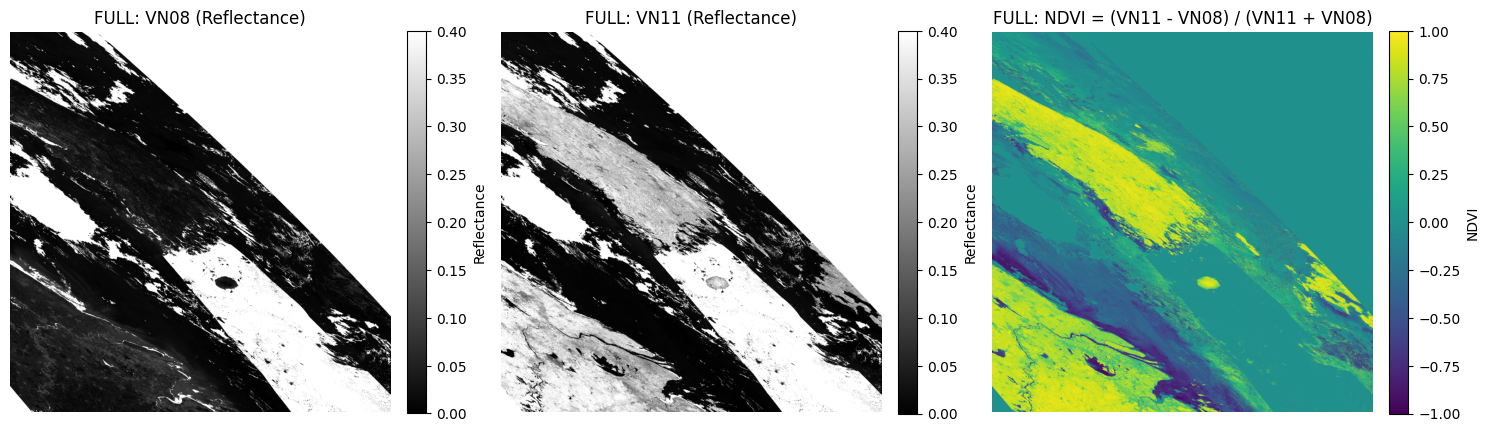

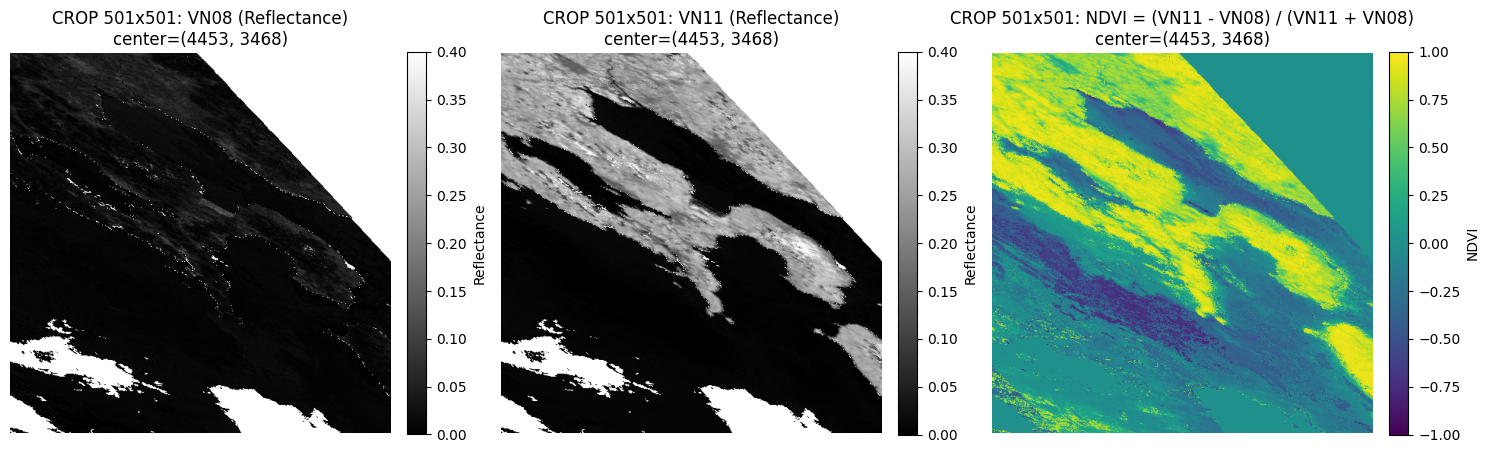

In [10]:

vn08_path = "data/Rs_VN08_reflectance_le_f32.bin"
vn11_path = "data/Rs_VN11_reflectance_le_f32.bin"

vn08 = load_bin(vn08_path)
vn11 = load_bin(vn11_path)

vn08m, vn11m, invalid = preprocess_reflectance(vn08, vn11)
ndvi = compute_ndvi(vn08m, vn11m)

cmap_ref, cmap_ndvi = make_cmaps(bad_color="blue")

# 1) 全体表示
plot_triplet(vn08m, vn11m, ndvi,
             title_prefix="FULL: ",
             cmap_ref=cmap_ref, cmap_ndvi=cmap_ndvi)

# 2) クロップ表示
# SGLI -> numpy index
col = int(round(imgX - 0.5))
row = int(round(imgY - 0.5))
size = 501
vn08c, center = crop_center_pad(vn08m, col, row, size=size)
vn11c, _      = crop_center_pad(vn11m, col, row, size=size)
ndvic, _      = crop_center_pad(ndvi,  col, row, size=size)

plot_triplet(vn08c, vn11c, ndvic,
             title_prefix=f"CROP {size}x{size}: ",
             center=center,
             cmap_ref=cmap_ref, cmap_ndvi=cmap_ndvi)
